In [1]:
import sys
dir_repo = '../../'
sys.path.append(dir_repo)

from emu_Nx2pt.utils import get_config_from_yaml
from emu_Nx2pt.mlp_emulator import MLP_Emulator

! rm -rf /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test/

In [2]:
config = get_config_from_yaml(dir_repo+'configs/mlp_test.yaml')
emu = MLP_Emulator(config=config)


------ Parameters ------

exp_name : mlp_test
cuda : True
ngpu : 1
gpu_device : 0
workers : 2
dir_output : /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments
dir_dataT : /home/hhg/Research/emu_Nx2pt/data/train_1M/
filename_pco : /home/hhg/Research/emu_Nx2pt/data/pco_train_1000000.pkl
startID : 0
endID : 10000
f_train : 0.7
seed : 3
Nhidden : 64
Nblocks : 2
num_epochs : 10
batch_size : 64
lr : 0.01
beta1 : 0.5
beta2 : 0.999
step_size : 5
gamma : 0.1
early_stop_threshold : 10
file_cov : /home/hhg/Research/emu_Nx2pt/data/cov3500.pkl
file_mask : /home/hhg/Research/emu_Nx2pt/data/10x2pt_RomanxSO_fid_mask.txt

------ Prepare Data ------

Number of train samples: 7000 (110 batches)
Number of valid samples: 3000 (47 batches)

------ Build Model ------

MLP(
  (in_layer): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
  )
  (mid_layers): ModuleDict(
    (block_0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      

In [3]:
emu.train()


------ Create experiment directory ------

Training information will be stored at :
 	 /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test
--- Epoch 1/10 ---
	train avg_chi2: 198865.87	valid avg_chi2: 90599.03	Time: 0m 3s
--- Epoch 2/10 ---
	train avg_chi2: 91584.58	valid avg_chi2: 84164.75	Time: 0m 2s
--- Epoch 3/10 ---
	train avg_chi2: 84497.81	valid avg_chi2: 69300.47	Time: 0m 2s
--- Epoch 4/10 ---
	train avg_chi2: 76434.40	valid avg_chi2: 68497.43	Time: 0m 2s
--- Epoch 5/10 ---
	train avg_chi2: 71981.36	valid avg_chi2: 61914.11	Time: 0m 2s
--- Epoch 6/10 ---
	train avg_chi2: 62104.81	valid avg_chi2: 60657.10	Time: 0m 2s
--- Epoch 7/10 ---
	train avg_chi2: 61771.32	valid avg_chi2: 60299.26	Time: 0m 2s
--- Epoch 8/10 ---
	train avg_chi2: 61477.31	valid avg_chi2: 60062.39	Time: 0m 2s
--- Epoch 9/10 ---
	train avg_chi2: 61249.49	valid avg_chi2: 59811.09	Time: 0m 2s
--- Epoch 10/10 ---
	train avg_chi2: 61015.74	valid avg_chi2: 59662.76	Time: 0m 2s

Minimum (epoch-aver

## Plots: Training States

In [4]:
import numpy as np
import torch

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=16)

In [5]:
trainInfo = torch.load(emu.file_trainInfo)

In [6]:
trainInfo.keys()

dict_keys(['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr', 'best_epochID', 'best_model_wts'])

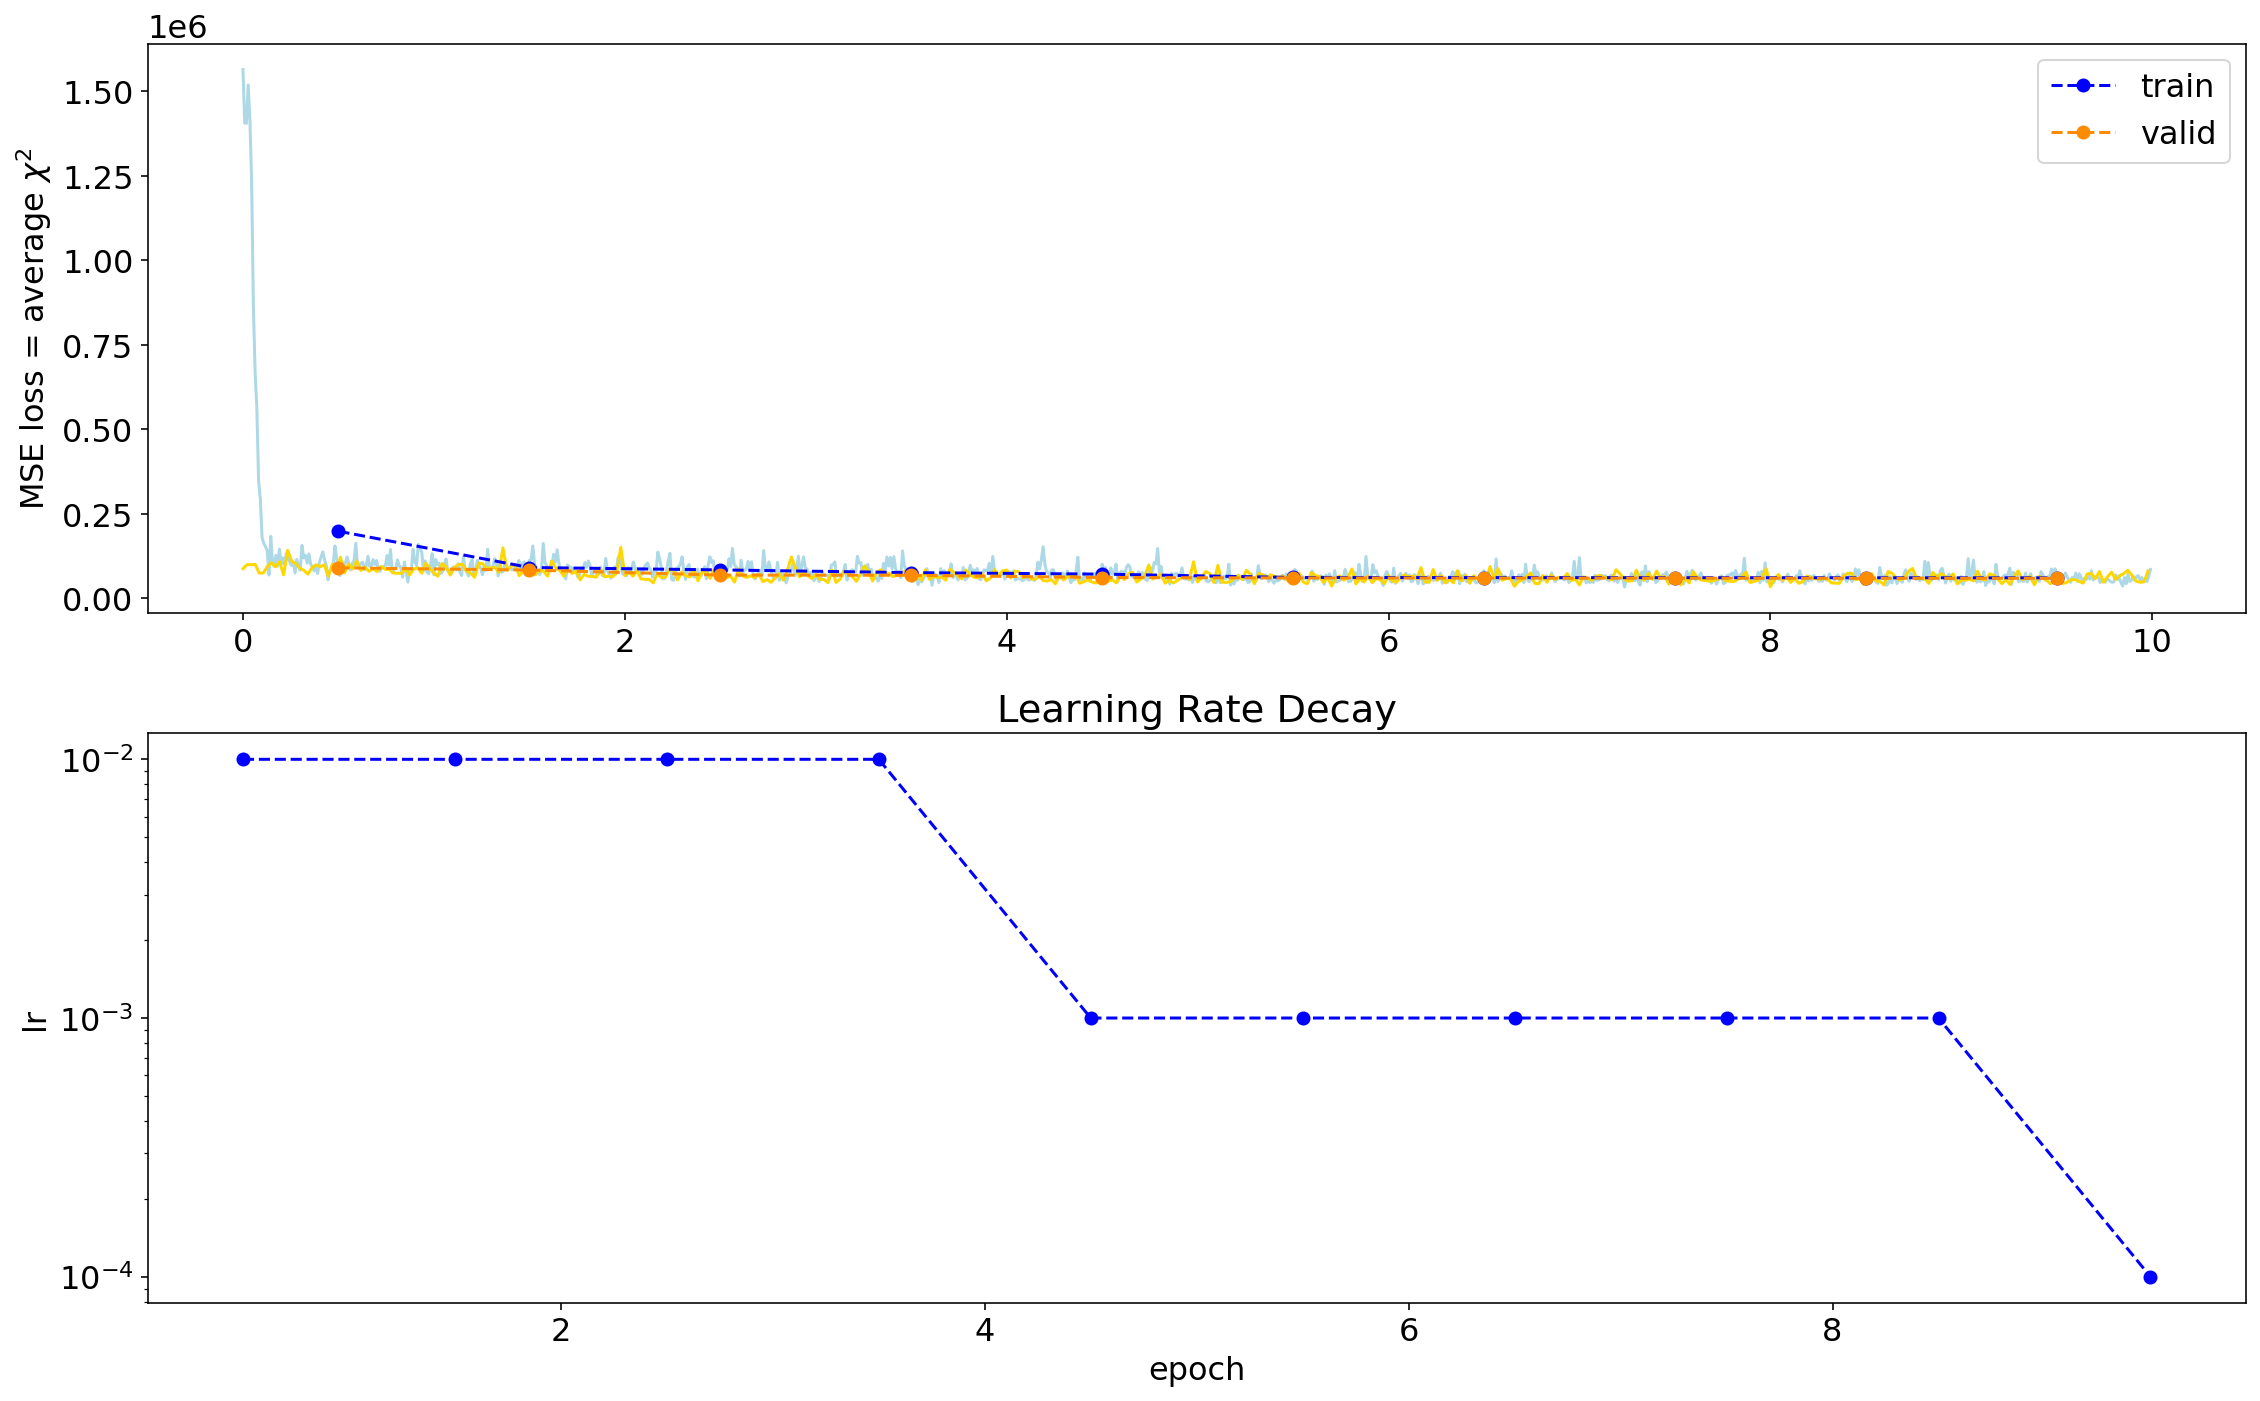

In [11]:
iter_tick = {}
for phase in ['train', 'valid']:
    iter_tick[phase] = np.array(range(len(trainInfo[f'{phase}_loss'])))/len(emu.dataloader[phase])

epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5

# --------------------------

plt.figure(figsize=(16,10))

plt.subplot(211)

n = 1
plt.plot(iter_tick['train'][::n], trainInfo['train_loss'][::n], color='lightblue')
plt.plot(iter_tick['valid'][::n], trainInfo['valid_loss'][::n], color='gold')

plt.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='train', color='b')
plt.plot(epoch_tick, trainInfo['epoch_valid_loss'], 'o--', label='valid', color='darkorange')

plt.ylabel('MSE loss = average $\chi^2$')

plt.legend()

#plt.xlim([10,20])
#plt.ylim([0,10000])


plt.subplot(212)
plt.plot(epoch_tick, trainInfo['lr'], 'o--', label='train', color='b' )
plt.title('Learning Rate Decay')
plt.ylabel('lr')
plt.yscale('log')
plt.xlabel('epoch')


plt.tight_layout()

## Check the Performance of the Best Trained Emulator

In [36]:
import pandas as pd
import pickle
from emu_Nx2pt.data_kits import dataTDataset
from torch.utils.data import DataLoader

In [37]:
emu.model.load_state_dict(trainInfo['best_model_wts'])

<All keys matched successfully>

In [38]:
startID, endID = 900000, 1000000

with open(emu.filename_pco, 'rb') as handle:
    pco_samples = pickle.load(handle)

test_pco = pd.DataFrame(pco_samples).iloc[startID:endID]

testID = list(range(startID, endID))
test_dataset = dataTDataset(testID, test_pco, emu.dir_dataT)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [51]:
test_dataset.IDs[0]

900000

In [56]:
test_dataset.df_pco.iloc[[0]]

,Omega_m,sigma_8,n_s,w0,wa,Omega_b,h0,A_ia,eta_ia,gas_0,gas_1,gas_2,gas_3,gas_7,gas_8,gas_9,gas_10
900000,0.338325,0.820367,0.937533,-1.047227,-0.463518,0.050832,0.661901,0.434124,-0.40235,1.16804,0.927435,13.490479,0.883881,6.58618,0.787829,0.019413,0.182688


In [58]:
test_dataset.df_pco.iloc[[0]].values[0]

array([ 0.33832546,  0.82036681,  0.93753324, -1.04722711, -0.46351838,
        0.05083243,  0.66190136,  0.43412405, -0.40235014,  1.16804001,
        0.9274353 , 13.49047865,  0.88388052,  6.58617968,  0.78782905,
        0.01941312,  0.1826878 ])

In [60]:
test_dataset.df_pco.loc[[900000]]

,Omega_m,sigma_8,n_s,w0,wa,Omega_b,h0,A_ia,eta_ia,gas_0,gas_1,gas_2,gas_3,gas_7,gas_8,gas_9,gas_10
900000,0.338325,0.820367,0.937533,-1.047227,-0.463518,0.050832,0.661901,0.434124,-0.40235,1.16804,0.927435,13.490479,0.883881,6.58618,0.787829,0.019413,0.182688


In [52]:
pco, dataT = test_dataset.__getitem__(0)

IndexError: positional indexers are out-of-bounds

In [24]:
validSamples = iter(emu.dataloader['valid'])

ID = 2
pco, datav = validSamples.next()
pco = pco.to(emu.device)[ID]

In [25]:
emu_dataV = emu.model(pco)

In [28]:
emu.dataloader['valid'].dataset.IDs

[5876,
 6555,
 1448,
 3351,
 231,
 1204,
 1911,
 9648,
 8438,
 7541,
 2589,
 977,
 4684,
 3814,
 4023,
 4189,
 9246,
 9004,
 4646,
 8730,
 7910,
 3740,
 2675,
 7111,
 2423,
 5642,
 850,
 898,
 6336,
 2471,
 2849,
 6912,
 7333,
 7961,
 5387,
 194,
 8544,
 7785,
 6762,
 5094,
 5967,
 9490,
 7072,
 6683,
 1897,
 577,
 6328,
 2230,
 4008,
 1008,
 7175,
 3520,
 4328,
 3346,
 4119,
 6461,
 2814,
 9267,
 4436,
 4995,
 2130,
 7822,
 1364,
 5294,
 247,
 8375,
 2960,
 2644,
 965,
 5564,
 7156,
 2782,
 6620,
 8721,
 5734,
 232,
 1103,
 9927,
 4480,
 6978,
 5513,
 4702,
 955,
 7936,
 3514,
 7515,
 4990,
 5308,
 368,
 2176,
 9805,
 7382,
 5708,
 3222,
 1377,
 7255,
 2083,
 3761,
 4473,
 1631,
 5170,
 1628,
 4370,
 8006,
 8086,
 4557,
 8489,
 455,
 3491,
 922,
 367,
 9033,
 5266,
 2438,
 4934,
 213,
 3138,
 7350,
 5030,
 9244,
 9580,
 2099,
 4770,
 6010,
 6554,
 7566,
 2371,
 5489,
 8874,
 8447,
 1951,
 4024,
 1162,
 1030,
 6858,
 6521,
 3636,
 9773,
 679,
 6480,
 7811,
 5132,
 380,
 8674,
 9730,
 4